In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset

In [2]:
df = pd.read_csv('/home/tang/Documents/DSBA/ML/sarcasm/train-balanced-sarcasm.csv')
df = df[['comment', 'label']]
df = df.dropna(subset=['comment'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   comment  1010771 non-null  object
 1   label    1010771 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [3]:
df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [20]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['label'])

In [21]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [22]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [23]:
def preprocess(txt):
    return tokenizer(txt['comment'],truncation=True)

In [24]:
train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/505385 [00:00<?, ? examples/s]

Map:   0%|          | 0/505386 [00:00<?, ? examples/s]

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [27]:
training_args = TrainingArguments(
    output_dir='/home/tang/Documents/DSBA/ML/sarcasm/results_sarcasm2',
    num_train_epochs=2,             
    per_device_train_batch_size=16,    
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=True,
    disable_tqdm=False,
    remove_unused_columns=True,
)

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.552600,0.503390,0.759671,0.748005
2,0.410400,0.503517,0.764430,0.762067


TrainOutput(global_step=63174, training_loss=0.48124784750299404, metrics={'train_runtime': 4008.033, 'train_samples_per_second': 252.186, 'train_steps_per_second': 15.762, 'total_flos': 1.0275540873238044e+16, 'train_loss': 0.48124784750299404, 'epoch': 2.0})

In [30]:
trainer.save_model('/home/tang/Documents/DSBA/ML/sarcasm/results_sarcasm2')


In [ ]:
eval_results = trainer.evaluate()

In [39]:
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Test F1 Score: {eval_results['eval_f1']:.4f}")

Test Accuracy: 0.7644
Test F1 Score: 0.7621


In [82]:
df_twitter = pd.read_csv('/home/tang/Documents/DSBA/ML/sarcasm/twitter_data.csv')
df_twitter.head()

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative


In [83]:
df_twitter = df_twitter.rename(columns={"tweets": "comment", "class": "label"})
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81408 entries, 0 to 81407
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  81408 non-null  object
 1   label    81408 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [84]:
df_twitter['label'].value_counts()

label
figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: count, dtype: int64

In [85]:
df_twitter['label'] = df_twitter['label'].apply(lambda x: 1 if x == 'sarcasm' else 0)
df_twitter['label'].value_counts()

label
0    60727
1    20681
Name: count, dtype: int64

In [86]:
df_sarcasm = df_twitter[df_twitter['label'] == 1]     # minority class (sarcasm)
df_not_sarcasm = df_twitter[df_twitter['label'] == 0] # majority class (all others)

count_sarcasm = len(df_sarcasm)

df_not_sarcasm_under = df_not_sarcasm.sample(n=count_sarcasm, random_state=42)

# Combine the undersampled majority class with the minority class
df_balanced = pd.concat([df_sarcasm, df_not_sarcasm_under])

# Shuffle the rows (optional but recommended)
df_twitter = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41362 entries, 0 to 41361
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  41362 non-null  object
 1   label    41362 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 646.4+ KB


In [87]:
df_twitter['label'].value_counts()

label
1    20681
0    20681
Name: count, dtype: int64

In [88]:
df_twitter = Dataset.from_pandas(df_twitter)

In [89]:
df_twitter = df_twitter.map(preprocess, batched=True)

Map:   0%|          | 0/41362 [00:00<?, ? examples/s]

In [90]:
predictions_twi = trainer.predict(df_twitter)

In [91]:
logits = predictions_twi.predictions

pred_labels = np.argmax(logits, axis=1)

In [92]:
true_labels = predictions_twi.label_ids
acc = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Test Accuracy: 0.7750
Test F1 Score: 0.7725


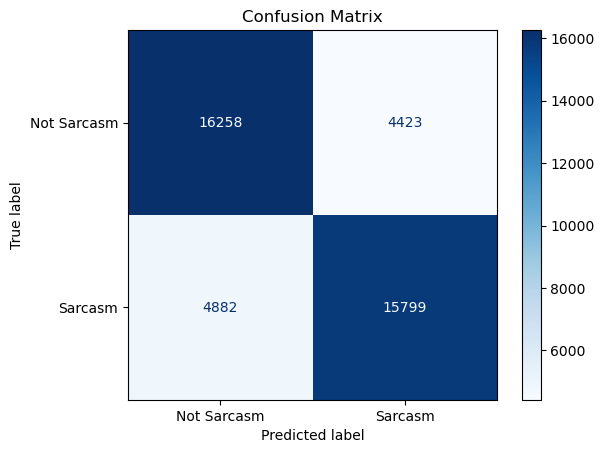

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)

labels = ['Not Sarcasm', 'Sarcasm']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()